In [1]:
import pandas as pd
import numpy as np
import datetime
from datetime import datetime
from pytz import timezone
import math
import matplotlib.pyplot as plt

In [2]:
reddit_df = pd.read_csv('reddit_text_sentiment.csv')
stocks_df = pd.read_csv("../data/stocks/csv/stock_prices.csv")
companies_df = pd.read_csv("../data/stocks/csv/companies.csv")
brands_df = pd.read_csv("../data/stocks/csv/brands.csv")
industries_df = pd.read_csv("../data/stocks/csv/industries.csv")

In [3]:
stocks_df = pd.read_csv("../data/stocks/csv/stock_prices.csv")

In [5]:
#helper function to convert utc to EST date
eastern = timezone('US/Eastern')
def utc_to_est(utc):
    return datetime.fromtimestamp(utc, tz = eastern)

In [6]:
#create new stocks column with datetime format of daily market close times
stocks_df["date"] = pd.to_datetime(stocks_df["date"]).values.astype(np.int64) // 10**6
stocks_df["date"] = (stocks_df["date"] + 57600000)//1000
stocks_df['datetime'] = stocks_df['date'].apply(utc_to_est)

In [7]:
#created new reddit column with datetime format of daily market close times
reddit_df['datetime'] = reddit_df['created_utc'].apply(utc_to_est)

In [8]:
#select relevant columns
reddit_df = reddit_df[['subreddit', 'datetime', 'score', 'compound', 'positive', 'neutral', 'negative']]

#add column that helps in counting posts when grouped
reddit_df['num_posts'] = 1

#replace zeros with insubstatial float in reddit scores
reddit_df.score = reddit_df.score.apply(lambda x: max(x, 0.01))

#weighted scores
for s in ['compound', 'negative', 'positive', 'neutral']:
    reddit_df['weighted_{0}'.format(s)] = reddit_df[s]*reddit_df['score'].apply(lambda x: math.log(x+1))
    
#add company_id as column
reddit_df = reddit_df.merge(brands_df[['subreddit', 'company_id']], on='subreddit')

In [9]:
#helper function that takes a dataframe and returns separate dataframes for each company
def separate_reddit(reddit_df, by='all'):
    if by not in ['all', 'company', 'industry']:
        print('argument invalid: must be = <all>, <company>, or <industry>')
        pass
    else:
        if by == 'industry':
            temp = reddit_df.merge(companies_df[['id', 'industry_id']], left_on = 'company_id', right_on='id')
            return [temp[temp['industry_id']==i][['industry_id', 'datetime','weighted_compound', 'weighted_negative', 'weighted_positive', 'weighted_neutral', 'num_posts']] for i in temp.industry_id.unique()]
        elif by == 'company':
            return [reddit_df[reddit_df['company_id']==i][['company_id', 'datetime','weighted_compound', 'weighted_negative', 'weighted_positive', 'weighted_neutral', 'num_posts']] for i in reddit_df.company_id.unique()]
        else:
            return [reddit_df[['company_id', 'datetime','weighted_compound', 'weighted_negative', 'weighted_positive', 'weighted_neutral', 'num_posts']]]

In [10]:
#groups data for a single company using sliding window - number of days specified in call
def group_data(df, by='all', days = 1):
    if by not in ['all', 'company', 'industry']:
        print('invalid arg: must be in [all, company, industry]')
        pass
    else:
        if by=='industry':
            i_id = df.industry_id.unique()[0] #save industry_id
            temp_df = df[['datetime', 'weighted_compound', 'weighted_positive', 'weighted_neutral', 'weighted_negative', 'num_posts']].groupby(pd.Grouper(key='datetime', freq='24h', base=11, label='right')).sum() #groupby day
            min_date = min(temp_df.index)
            max_date = max(temp_df.index)
            date_idx = [i for i in pd.date_range(min_date, max_date)] #new index
            temp_df = temp_df.reindex(date_idx).fillna(0).rolling(days).sum()[days-1:] #make dataframe with rolling window sum
            temp_df['industry_id'] = i_id #restore industry_id
            temp_df.reset_index(inplace=True)
            return temp_df
        elif by=='company':
            c_id = df.company_id.unique()[0] #save company_id
            temp_df = df[['datetime', 'weighted_compound', 'weighted_positive', 'weighted_neutral', 'weighted_negative', 'num_posts']].groupby(pd.Grouper(key='datetime', freq='24h', base=11, label='right')).sum() #groupby day
            min_date = min(temp_df.index)
            max_date = max(temp_df.index)
            date_idx = [i for i in pd.date_range(min_date, max_date)] #new index
            temp_df = temp_df.reindex(date_idx).fillna(0).rolling(days).sum()[days-1:] #make dataframe with rolling window sum
            temp_df['company_id'] = c_id #restore company_id
            temp_df.reset_index(inplace=True)
            return temp_df
        else:
            return pd.concat([group_data(d, 'company', days) for d in separate_reddit(df, 'company')])
    
    

In [16]:
def make_dataframes(df, separation='all', lookback=1, min_date = None, max_date = None):
    if min_date:
        df = df[df['datetime'] >= pd.to_datetime(min_date).tz_localize('US/Eastern')]
    if max_date:
        df = df[df['datetime'] <= pd.to_datetime(max_date).tz_localize('US/Eastern')]
    dfs = []
    separated = separate_reddit(df, separation)
    for d in separated:
        temp = group_data(d, separation, lookback)
        for i in ['weighted_compound', 'weighted_negative', 'weighted_positive', 'weighted_neutral']: #iterate over scores columns
            temp['avg_{}'.format(i)] = temp[i]/temp['num_posts'].apply(lambda x: max(x, 1)) #set avgerage weighted scores columns
        temp = temp.merge(stocks_df[['company_id', 'datetime', 'change_percent']], on=['company_id', 'datetime']) #add change_percent column
        dfs.append(temp)
    return dfs
        

In [33]:
model_dfs = make_dataframes(reddit_df, lookback = 1, min_date = '2014-03-01')

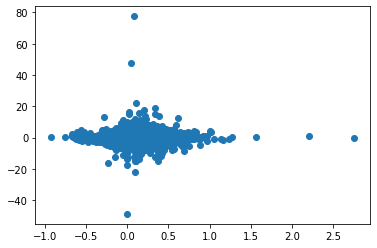

In [56]:
plt.scatter(model_dfs[0].avg_weighted_compound, model_dfs[0].change_percent)

In [61]:
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [95]:
#helper function that finds optimal C for a given training set (logistic regression)
def cross_validate_logreg(X_train, y_train, c_s = [0.1, 0.3, 1, 3, 10, 30, 100]):
    c_s = [0.1, 0.3, 1, 3, 10, 30, 100]
    lg_cv = LogisticRegressionCV(Cs = c_s, scoring='f1').fit(X_train, y_train)
    return c_s[np.argmax(np.mean(lg_cv.scores_[True],axis=0))], np.max(np.mean(lg_cv.scores_[True], axis=0))

In [98]:
def logreg_by_lookback(reddit_df, lookback = [1], c_s = [0.1, 0.3, 1, 3, 10, 30, 100]):
    for i in lookback:
        full_df = make_dataframes(reddit_df, lookback = i, min_date = '2014-03-01')[0]
        X = full_df[['avg_weighted_compound', 'avg_weighted_positive', 'avg_weighted_negative', 'avg_weighted_neutral', 'num_posts']]
        y = full_df['change_percent'] > 0
        X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.25, random_state = 6240)
        best_c, f1_score = cross_validate_logreg(X_train, y_train, c_s)
        print('Best f1_score = {0} for {1} day lookback with C = {2}'.format(f1_score, i, best_c))

In [99]:
logreg_by_lookback(reddit_df, lookback = [1, 3, 6, 10, 15])

C:\Users\ptbut\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best f1_score = 0.6844993070286836 for 1 day lookback with C = 0.1


C:\Users\ptbut\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best f1_score = 0.6845026628116683 for 3 day lookback with C = 0.1


C:\Users\ptbut\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best f1_score = 0.6507838626984754 for 6 day lookback with C = 0.1


C:\Users\ptbut\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best f1_score = 0.6825146042805549 for 10 day lookback with C = 0.1


C:\Users\ptbut\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best f1_score = 0.6855929478481713 for 15 day lookback with C = 30


In [106]:
#test out best logistic regression model
full_df = make_dataframes(reddit_df, lookback = 15, min_date = '2014-03-01')[0]
X = full_df[['avg_weighted_compound', 'avg_weighted_positive', 'avg_weighted_negative', 'avg_weighted_neutral', 'num_posts']]
y = full_df['change_percent'] > 0
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.25, random_state = 6240)
lg = LogisticRegression(C=30).fit(X_train, y_train)
lg_preds = lg.predict(X_test)
f1 = f1_score(lg_preds, y_test)
print('f1 score :{0}'.format)

<built-in method format of str object at 0x000001A297D4D170>


C:\Users\ptbut\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [104]:
##Baseline tests for linear regression
lookback_days = [1, 3, 6, 10, 15]
for i in lookback_days:
    full_df = make_dataframes(reddit_df, lookback = i, min_date = '2014-03-01')[0]
    X = full_df[['avg_weighted_compound', 'avg_weighted_positive', 'avg_weighted_negative', 'avg_weighted_neutral', 'num_posts']]
    y = full_df['change_percent']
    X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.25, random_state = 6240)
    ln = LinearRegression(normalize=True).fit(X_train, y_train)
    ln_pred = ln.predict(X_test)
    ln_f1 = f1_score((ln_pred > 0), y_test >0)
    print('r-squared for {0} day lookup is {1}'.format(i, ln.score(X_train, y_train)))
    print('f1 for {0} day lookup is {1}'.format(i, ln_f1))

r-squared for 1 day lookup is 0.0007246047514668508
f1 for 1 day lookup is 0.6702033598585323
r-squared for 3 day lookup is 0.0005415447738095214
f1 for 3 day lookup is 0.6798283261802576
r-squared for 6 day lookup is 0.001932734096405375
f1 for 6 day lookup is 0.5962666666666666
r-squared for 10 day lookup is 0.0007407773187453337
f1 for 10 day lookup is 0.6909402441636323
r-squared for 15 day lookup is 0.0006469767110658386
f1 for 15 day lookup is 0.6789748045178107
